### Two set of metrics are demonstrated for all data
1. 80-20 validation, with validation error demonstrated as peformance metric. The 80-20 validation is used for selecting the 2D descriptors
2. five-fold cross validation, with average CV error demonstrated as performance metric

* Note1: The Ehull value shows in the data are actually Ehull (1000K), this is calculated by Ehull(1000K) = Ehull(DFT) - S_ideal*1000K. The reason of doing that is because we use Ehull(1000K) to seperate GS/LS with US NASICONs
* Note 2: The same data can be reproduced with sklearn version 0.23.2. If you are using different version or have problem reproducing the 5-fold cross validation. You can use the *.dat files to reproduce the SVC model

In [1]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import os
from sklearn.metrics import accuracy_score, f1_score, recall_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC,SVC
from copy import deepcopy
import json
from matplotlib import pyplot as plt

from pymatgen.core.composition import Composition


prefix = os.getcwd()

In [2]:
# Note, the train test data here are from 80-20 data splitting. Which is used for SIS+MLR screening of 2D descriptors

train_2D_df = pd.read_csv('train_2D.csv')
test_2D_df = pd.read_csv('test_2D.csv')

In [3]:
train_2D_df.head()

,CompName,Ehull,(cbrt(NNaLst)+(AnionChgStdLst)^2),((EWaldSumLst)^2*(XWithNaLst*RDiffStdLst))
0,MgZr(SO4)3,-60.260567,0.0,0.000000
1,MgTi(SO4)3,-27.986572,0.0,125.960243
2,MgSn(SO4)3,-30.640966,0.0,46.109451
3,Mg4Nb2(SO4)9,-42.783127,0.0,79.651306
4,ZrZn(SO4)3,-40.419098,0.0,24.253452


In [4]:
Ehull_train = train_2D_df['Ehull'].to_numpy()
Y_total = np.zeros_like(Ehull_train)
Y_total[np.where(Ehull_train<=0)] = 0
Y_total[np.where(Ehull_train>0)] = 1
X_total = train_2D_df[['(cbrt(NNaLst)+(AnionChgStdLst)^2)','((EWaldSumLst)^2*(XWithNaLst*RDiffStdLst))']].to_numpy()

Ehull_test = test_2D_df['Ehull'].to_numpy()
Y_valid = np.zeros_like(Ehull_test)
Y_valid[np.where(Ehull_test<=0)] = 0
Y_valid[np.where(Ehull_test>0)] = 1
X_valid = test_2D_df[['(cbrt(NNaLst)+(AnionChgStdLst)^2)','((EWaldSumLst)^2*(XWithNaLst*RDiffStdLst))']].to_numpy()
print(np.unique(Y_total),np.unique(Y_valid))

[0. 1.] [0. 1.]


## Performance metric on 20% of the validation data (out of the training sample)

In [5]:
# The SVC validation error from 80-20 splitting

clf = SVC(kernel='linear',class_weight='balanced',probability=True)
clf.fit(X_total,Y_total)
Y_valid_predict = clf.predict(X_valid)
test_score = accuracy_score(Y_valid,Y_valid_predict)
test_recall_avg = recall_score(Y_valid,Y_valid_predict,average='macro')
test_recall_LSGS = recall_score(Y_valid,Y_valid_predict,pos_label=0)
test_recall_US = recall_score(Y_valid,Y_valid_predict,pos_label=1)
test_F1_avg = f1_score(Y_valid,Y_valid_predict,average='macro')
test_F1_LSGS = f1_score(Y_valid,Y_valid_predict,pos_label=0)
test_F1_US = f1_score(Y_valid,Y_valid_predict,pos_label=1)

print(f'LSGS recall = {test_recall_LSGS}, US recall = {test_recall_US}')
print(f'LSGS F1 = {test_F1_LSGS}, US F1 = {test_F1_US}')
print(f'Accuracy = {test_score}, recall = {test_recall_avg}, F1 score = {test_F1_avg}')

LSGS recall = 0.796875, US recall = 0.8289676425269645
LSGS F1 = 0.5982404692082111, US F1 = 0.8870568837592745
Accuracy = 0.8236808236808236, recall = 0.8129213212634823, F1 score = 0.7426486764837428


## Performance metric on five fold cross validation

In [6]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [7]:
X_all_data = np.concatenate((X_total,X_valid))
Y_all_data = np.concatenate((Y_total,Y_valid))
ehull_all_data = np.concatenate((Ehull_train,Ehull_test))

In [8]:
print(Y_all_data.shape,X_all_data.shape)

(3881,) (3881, 2)


In [9]:
# The real train set = train set from skf + the validation data set
accuracy_lst, recall_lst, F1_lst, clf_lst, best_train_index_lst, best_test_index_lst, best_test_score_lst = \
    [], [], [], [], [], [], []

best_test_score = 0.0
count = 1

for train_index, test_index in skf.split(X_all_data,Y_all_data):
    print(f"============Performing fold {count}===================")
    X_train = X_all_data[train_index]
    X_test = X_all_data[test_index]
    Y_train = Y_all_data[train_index]
    Y_test = Y_all_data[test_index]
    
    clf = SVC(kernel='linear',class_weight='balanced',probability=True)

    clf.fit(X_train, Y_train)
    Y_cv_predict = clf.predict(X_test)
    
    test_score = accuracy_score(Y_test,Y_cv_predict)
    test_recall_avg = recall_score(Y_test,Y_cv_predict,average='macro')
    test_recall_LSGS = recall_score(Y_test,Y_cv_predict,pos_label=0)
    test_recall_US = recall_score(Y_test,Y_cv_predict,pos_label=1)
    test_F1 = f1_score(Y_test,Y_cv_predict,average='macro')
    test_F1_LSGS = f1_score(Y_test,Y_cv_predict,pos_label=0)
    test_F1_US = f1_score(Y_test,Y_cv_predict,pos_label=1)
    
    accuracy_lst.append(test_score)
    recall_lst.append(test_recall_avg)
    F1_lst.append(test_F1)
    clf_lst.append(deepcopy(clf))
    best_test_score_lst.append(test_score)
    best_train_index_lst.append(train_index)
    best_test_index_lst.append(test_index)
    
    
    print(f'LSGS recall = {test_recall_LSGS}, US recall = {test_recall_US}')
    print(f'LSGS F1 = {test_F1_LSGS}, US F1 = {test_F1_US}')
    print(f'Accuracy = {test_score}, average recall = {test_recall_avg}, average F1 score = {test_F1}')
    
    np.savetxt(f'train_X_fold{count}.dat',X_train)
    np.savetxt(f'test_X_fold{count}.dat',X_test)
    np.savetxt(f'train_Y_fold{count}.dat',Y_train)
    np.savetxt(f'test_Y_fold{count}.dat',Y_test)
        
    count += 1
    
print(f'Average accuracy = {np.average(accuracy_lst)}, recall = {np.average(recall_lst)}, F1 score = {np.average(F1_lst)}')

============Performing fold 1===================
LSGS recall = 0.875968992248062, US recall = 0.8209876543209876
LSGS F1 = 0.6312849162011173, US F1 = 0.8896321070234113
Accuracy = 0.8301158301158301, average recall = 0.8484783232845248, average F1 score = 0.7604585116122643
============Performing fold 2===================
LSGS recall = 0.828125, US recall = 0.8024691358024691
LSGS F1 = 0.5856353591160222, US F1 = 0.8739495798319329
Accuracy = 0.8067010309278351, average recall = 0.8152970679012346, average F1 score = 0.7297924694739775
============Performing fold 3===================
LSGS recall = 0.8125, US recall = 0.8132716049382716
LSGS F1 = 0.5892351274787536, US F1 = 0.8790658882402
Accuracy = 0.8131443298969072, average recall = 0.8128858024691358, average F1 score = 0.7341505078594768
============Performing fold 4===================
LSGS recall = 0.921875, US recall = 0.8302469135802469
LSGS F1 = 0.6629213483146068, US F1 = 0.899665551839465
Accuracy = 0.845360824742268, avera

In [10]:
# Select the best model that have F1 cloest to average F1 score

best_ind = 2
print(f'model {best_ind} is selected')
best_clf = clf_lst[best_ind]
best_train_index, best_test_index = best_train_index_lst[best_ind], best_test_index_lst[best_ind]
best_X_train, best_X_test = X_all_data[best_train_index,:], X_all_data[best_test_index,:]
best_Y_train, best_Y_test = Y_all_data[best_train_index], Y_all_data[best_test_index]

model 2 is selected


In [11]:
# Calculate the normalization factor to make sure the second feature dimensionaless

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df.set_index('CompName')
test_df = test_df.set_index('CompName')

e_Ewald_ref = train_df.loc['Na3Zr2Si2PO12']['EWaldSumLst']
r_ref = 1.02 # The shannon radius of Na+

norm_factor = 1/(e_Ewald_ref**2*r_ref)
print(f'norm_factor is {norm_factor}')

norm_factor is 0.0005422912481778321


In [12]:
# print model coeffcient

print(best_clf.coef_)
print(best_clf.intercept_)
x_coeff = best_clf.coef_[0][0]*norm_factor/best_clf.coef_[0][1]
y_coeff = 1.0
intercept = -best_clf.intercept_[0]*norm_factor/best_clf.coef_[0][1]
print(f'{x_coeff}x+y<={intercept}')

[[3.54999017 0.00946628]]
[-5.61898835]
0.20336704500404978x+y<=0.3218930202607268


## Plot all the data with the decision boundary that has highest validation accuracy/F1

(3105, 2) (3105,)


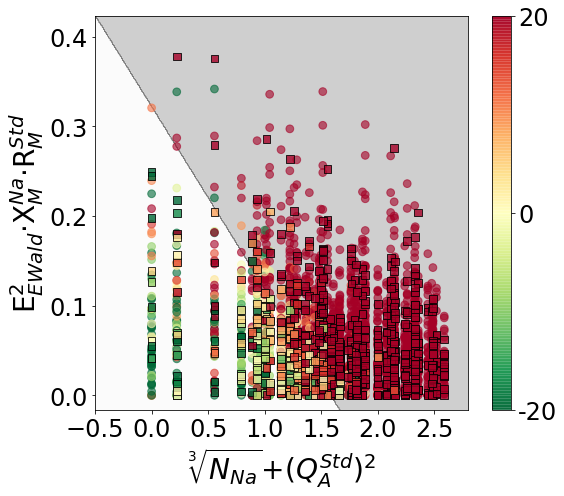

In [13]:
plt.figure(figsize=(8,7))
x_min, x_max = X_all_data[:,0].min()-0.5, X_all_data[:,0].max()+0.5
y_min, y_max = X_all_data[:,1].min()-50, X_all_data[:,1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]
print(best_X_train.shape,ehull_train_arry.shape)

plt.scatter(best_X_train[:,0],best_X_train[:,1],marker='o',s=[60 for i in range(ehull_train_arry.shape[0])],
            c=ehull_train_arry,cmap='RdYlGn_r',vmin=-20,vmax=20,alpha=0.6)
plt.scatter(best_X_test[:,0],best_X_test[:,1],marker='s',s=[60 for i in range(ehull_test_arry.shape[0])],
            c=ehull_test_arry,edgecolors=['k' for i in range(ehull_train_arry.shape[0])],
            cmap='RdYlGn_r',vmin=-20,vmax=20,alpha=0.8)


CB=plt.colorbar()
CB.ax.tick_params(labelsize=24)
CB.set_ticks([-20,0,20]); CB.set_ticklabels(['-20','0','20'])
_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8)) 
plt.ylim((-30,780))
plt.tight_layout()
plt.savefig('Fig_5a.pdf')

## plot experimentally reported NASICONs

In [14]:
import json

with open('exp_comps.json','r') as fid:
    exp_comp_dict = json.load(fid)
    
reported_exp_comps = exp_comp_dict['reported_exp_comps']
new_exp_comps = exp_comp_dict['new_exp_comps']

all_comp_names = train_2D_df['CompName'].to_list() + test_2D_df['CompName'].tolist()

reported_exp_inds = [all_comp_names.index(exp_comp) for exp_comp in reported_exp_comps]
new_exp_inds = [all_comp_names.index(exp_comp) for exp_comp in new_exp_comps]

print(len(reported_exp_comps), len(new_exp_comps))
print(len(reported_exp_inds), len(new_exp_inds))

27 5
27 5


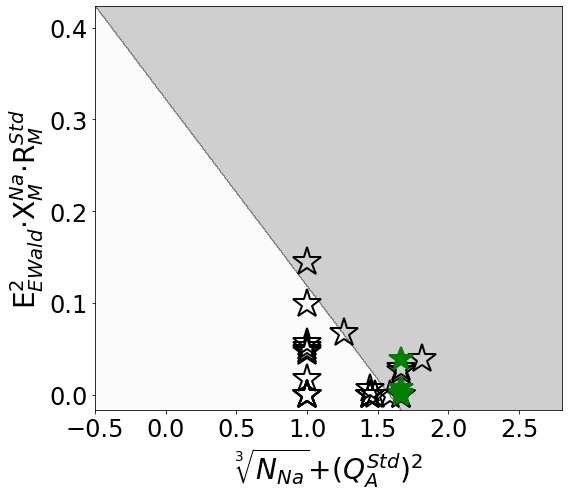

In [15]:
plt.figure(figsize=(8,7))
x_min, x_max = X_all_data[:,0].min()-0.5, X_all_data[:,0].max()+0.5
y_min, y_max = X_all_data[:,1].min()-50, X_all_data[:,1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]

plt.plot(X_all_data[reported_exp_inds,0],X_all_data[reported_exp_inds,1],'*',fillstyle='none',
         color='k',markersize=30,label='Reported NASICON',alpha=1.0,markeredgewidth=2)
plt.plot(X_all_data[new_exp_inds,0],X_all_data[new_exp_inds,1],'*',fillstyle='full',color='g',markersize=25,\
         label='This Work',alpha=1.0,markeredgewidth=2)
_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8)) 
plt.ylim((-30,780))
plt.tight_layout()
plt.savefig('Fig_5b.pdf')

In [28]:
# Print the probability predicted by best model
flags = ['Yes','No']
ratio = best_clf.class_weight_/best_clf.class_weight_.sum()
print(ratio)

fn_prob_lst = []
for exp_ind in reported_exp_inds + new_exp_inds:
    comp_name = all_comp_names[exp_ind]
    prob = best_clf.predict_proba(X_all_data[[exp_ind]])[0]
    prob *= ratio
    prob /= prob.sum()
    flag = flags[int(best_clf.predict(X_all_data[[exp_ind]])[0])]
    print(f'{comp_name}\t{prob[0]:.3f}\t{flag}')
    if flag == 'No':
        fn_prob_lst.append(prob[0])

print(f'Average probabiliy for false negative cases {np.average(fn_prob_lst)}')

[0.83478261 0.16521739]
Na3Zr2Si2PO12	0.431	No
Na4Zr2(SiO4)3	0.506	No
NaTi2(PO4)3	0.911	Yes
NaSn2(PO4)3	0.911	Yes
NaHf2(PO4)3	0.911	Yes
Na3MgZr(PO4)3	0.645	Yes
Na2Zr2Si(PO6)2	0.608	Yes
Na3ZrTiSi2PO12	0.301	No
Na3Ti2Si2PO12	0.431	No
Na3Sc2(PO4)3	0.645	Yes
Na3ZrZn(PO4)3	0.616	Yes
Na3Hf2Si2PO12	0.431	No
Na3Y2(PO4)3	0.645	Yes
Na4HfAlSi2PO12	0.168	No
NaAlZn(SO4)3	0.385	No
NaMgAl(SO4)3	0.602	Yes
NaZnIn(SO4)3	0.807	Yes
NaMgIn(SO4)3	0.801	Yes
Na3HfTiSi2PO12	0.314	No
NaGe2(PO4)3	0.911	Yes
NaTiGe(PO4)3	0.789	Yes
NaTiSn(PO4)3	0.776	Yes
NaZrSn(PO4)3	0.881	Yes
Na2ZrAl(PO4)3	0.503	No
Na3In2(PO4)3	0.645	Yes
NaZr2(PO4)3	0.911	Yes
Na3Al2(PO4)3	0.645	Yes
Na3HfZrSi2PO12	0.422	No
Na6Hf3MgSi2(PO6)4	0.423	No
Na3HfScSi(PO6)2	0.396	No
Na6CaHf3Si2(PO6)4	0.262	No
Na6MgZr3Si2(PO6)4	0.431	No
Average probabiliy for false negative cases 0.38586439458646143


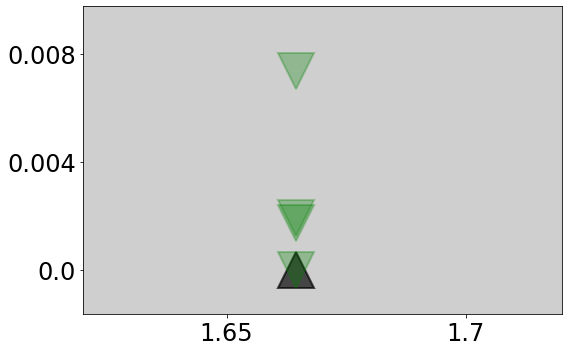

In [17]:
# Zoom in the five newly synthesized compounds

plt.figure(figsize=(8,5))

x_min, x_max = X_all_data[:,0].min()-0.5, X_all_data[:,0].max()+0.5
y_min, y_max = X_all_data[:,1].min()-50, X_all_data[:,1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]

plt.plot(X_all_data[reported_exp_inds,0],X_all_data[reported_exp_inds,1],'^',fillstyle='full',color='k',markersize=36,label='Reported NASICON',\
         alpha=0.3,markeredgewidth=2)
plt.plot(X_all_data[new_exp_inds,0],X_all_data[new_exp_inds,1],'v',fillstyle='full',color='g',markersize=36,\
         label='This Work',alpha=0.3,markeredgewidth=2,markeredgecolor='g')
plt.xlim((1.62,1.72)); plt.ylim((-3,18));
plt.xticks([1.65,1.7],[1.65,1.7],fontsize=24);
plt.yticks([0.00/norm_factor,0.004/norm_factor,0.008/norm_factor],
           [0.0,0.004,0.008],fontsize=24)
plt.tight_layout()
plt.savefig('Fig_5b_zoom.pdf')

## plot Na rich and Na poor NASICONs

In [18]:
def obtain_NNa(comp_lst):
    NNa_lst = []
    for reduced_formula in comp_lst:
        NNa = Composition(reduced_formula)['Na']/Composition(reduced_formula)['O']*12.0
        NNa_lst.append(NNa)
        
    return np.array(NNa_lst)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]
train_comp_names = [all_comp_names[i] for i in best_train_index]
test_comp_names = [all_comp_names[i] for i in best_test_index]

NNa_train_arry = obtain_NNa(train_comp_names)
NNa_test_arry = obtain_NNa(test_comp_names)

NaPoor_LSGS_train_ind = np.where((NNa_train_arry<=1.0) & (ehull_train_arry<=0))[0]
NaRich_LSGS_train_ind = np.where((NNa_train_arry>=3.0) & (ehull_train_arry<=0))[0]
NaPoor_LSGS_test_ind = np.where((NNa_test_arry<=1.0) & (ehull_test_arry<=0))[0]
NaRich_LSGS_test_ind = np.where((NNa_test_arry>=3.0) & (ehull_test_arry<=0))[0]

In [19]:
# The weighted ratio

ratio =  best_clf.class_weight_/best_clf.class_weight_.sum()
NaPoor_LSGS_train_proba = best_clf.predict_proba(best_X_train[NaPoor_LSGS_train_ind])*ratio
NaRich_LSGS_train_proba = best_clf.predict_proba(best_X_train[NaRich_LSGS_train_ind])*ratio
NaPoor_LSGS_test_proba = best_clf.predict_proba(best_X_test[NaPoor_LSGS_test_ind])*ratio
NaRich_LSGS_test_proba = best_clf.predict_proba(best_X_test[NaRich_LSGS_test_ind])*ratio

print(
    NaPoor_LSGS_train_proba.shape, NaRich_LSGS_train_proba.shape, \
    NaPoor_LSGS_test_proba.shape, NaRich_LSGS_test_proba.shape, \
    len(NaPoor_LSGS_train_ind), len(NaRich_LSGS_train_ind), \
    len(NaPoor_LSGS_test_ind), len(NaRich_LSGS_test_ind)
      )

(363, 2) (48, 2) (91, 2) (12, 2) 363 48 91 12


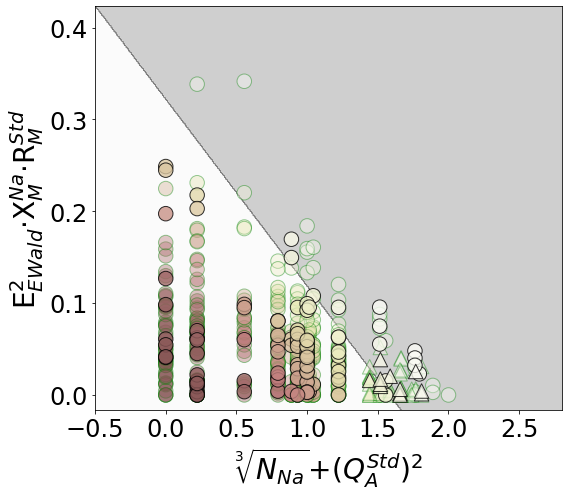

In [20]:
plt.figure(figsize=(8,7))
x_min, x_max = X_all_data[:,0].min()-0.5, X_all_data[:,0].max()+0.5
y_min, y_max = X_all_data[:,1].min()-50, X_all_data[:,1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]

plt.scatter(best_X_train[NaPoor_LSGS_train_ind,0],best_X_train[NaPoor_LSGS_train_ind,1],cmap='pink_r',marker='o',
         s=210,c=NaPoor_LSGS_train_proba[:,0],edgecolors=['g' for _ in range(len(NaPoor_LSGS_test_ind))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_train[NaRich_LSGS_train_ind,0],best_X_train[NaRich_LSGS_train_ind,1],cmap='pink_r',marker='^',
         s=210,c=NaRich_LSGS_train_proba[:,0],edgecolors=['g' for _ in range(len(NaPoor_LSGS_test_ind))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_test[NaPoor_LSGS_test_ind,0],best_X_test[NaPoor_LSGS_test_ind,1],cmap='pink_r',marker='o',
         s=210,c=NaPoor_LSGS_test_proba[:,0],edgecolors=['k' for _ in range(len(NaPoor_LSGS_test_ind))],alpha=0.8,
         vmin=0.0,vmax=1.0)
plt.scatter(best_X_test[NaRich_LSGS_test_ind,0],best_X_test[NaRich_LSGS_test_ind,1],cmap='pink_r',marker='^',
         s=210,c=NaRich_LSGS_test_proba[:,0],edgecolors=['k' for _ in range(len(NaRich_LSGS_test_ind))],alpha=0.8,
         vmin=0.0,vmax=1.0)

_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8)) 
plt.ylim((-30,780))
plt.tight_layout()
plt.savefig('Fig_5c.pdf')

In [21]:
# Print the probability predicted by best model
flags = ['Yes','No']
ratio = best_clf.class_weight_/best_clf.class_weight_.sum()
print(ratio)

for exp_ind in reported_exp_inds + new_exp_inds:
    comp_name = all_comp_names[exp_ind]
    prob = best_clf.predict_proba(X_all_data[[exp_ind]])[0]
    prob *= ratio
    prob /= prob.sum()
    flag = flags[int(best_clf.predict(X_all_data[[exp_ind]])[0])]
    print(f'{comp_name}\t{prob[0]:.3f}\t{flag}')

[0.83478261 0.16521739]
Na3Zr2Si2PO12	0.431	No
Na4Zr2(SiO4)3	0.506	No
NaTi2(PO4)3	0.911	Yes
NaSn2(PO4)3	0.911	Yes
NaHf2(PO4)3	0.911	Yes
Na3MgZr(PO4)3	0.645	Yes
Na2Zr2Si(PO6)2	0.608	Yes
Na3ZrTiSi2PO12	0.301	No
Na3Ti2Si2PO12	0.431	No
Na3Sc2(PO4)3	0.645	Yes
Na3ZrZn(PO4)3	0.616	Yes
Na3Hf2Si2PO12	0.431	No
Na3Y2(PO4)3	0.645	Yes
Na4HfAlSi2PO12	0.168	No
NaAlZn(SO4)3	0.385	No
NaMgAl(SO4)3	0.602	Yes
NaZnIn(SO4)3	0.807	Yes
NaMgIn(SO4)3	0.801	Yes
Na3HfTiSi2PO12	0.314	No
NaGe2(PO4)3	0.911	Yes
NaTiGe(PO4)3	0.789	Yes
NaTiSn(PO4)3	0.776	Yes
NaZrSn(PO4)3	0.881	Yes
Na2ZrAl(PO4)3	0.503	No
Na3In2(PO4)3	0.645	Yes
NaZr2(PO4)3	0.911	Yes
Na3Al2(PO4)3	0.645	Yes
Na3HfZrSi2PO12	0.422	No
Na6Hf3MgSi2(PO6)4	0.423	No
Na3HfScSi(PO6)2	0.396	No
Na6CaHf3Si2(PO6)4	0.262	No
Na6MgZr3Si2(PO6)4	0.431	No


In [22]:
Na_Poor_LSGS_predict = best_clf.predict(best_X_test[NaPoor_LSGS_test_ind,:])
Na_Poor_LSGS_recall = recall_score(best_Y_test[NaPoor_LSGS_test_ind],Na_Poor_LSGS_predict,pos_label=0)
Na_Poor_LSGS_f1 = f1_score(best_Y_test[NaPoor_LSGS_test_ind],Na_Poor_LSGS_predict,pos_label=0)
print(Na_Poor_LSGS_predict.shape)

Na_Rich_LSGS_predict = best_clf.predict(best_X_test[NaRich_LSGS_test_ind,:])
Na_Rich_LSGS_recall = recall_score(best_Y_test[NaRich_LSGS_test_ind],Na_Rich_LSGS_predict,pos_label=0)
Na_Rich_LSGS_f1 = f1_score(best_Y_test[NaRich_LSGS_test_ind],Na_Rich_LSGS_predict,pos_label=0)
print(Na_Rich_LSGS_predict.shape)

print(f'Na_Poor_LSGS_recall={Na_Poor_LSGS_recall}, Na_Rich_LSGS_recall={Na_Rich_LSGS_recall}')
print(f'Na_Poor_LSGS_f1 = {Na_Poor_LSGS_f1}, Na_Rich_LSGS_f1={Na_Rich_LSGS_f1}')

(91,)
(12,)
Na_Poor_LSGS_recall=0.8791208791208791, Na_Rich_LSGS_recall=0.25
Na_Poor_LSGS_f1 = 0.935672514619883, Na_Rich_LSGS_f1=0.4


## plot Ca/Ge and Hf/Zr NASICONs

In [23]:
def obtain_NASICON_with_metal(comp_lst,ehull_arry,metals):
    NASICON_comp_lst, NASICON_comp_inds = [], []
    for i, reduced_formula in enumerate(comp_lst):
        NM = 0.0
        for metal in metals:
            NM += Composition(reduced_formula)[metal]/Composition(reduced_formula)['O']*12.0
        if NM > 0.0 and ehull_arry[i] <= 0:
            NASICON_comp_lst.append(reduced_formula)
            NASICON_comp_inds.append(i)
        
    return NASICON_comp_lst, NASICON_comp_inds


ehull_train_arry = ehull_all_data[best_train_index]
ehull_test_arry = ehull_all_data[best_test_index]
train_comp_names = [all_comp_names[i] for i in best_train_index]
test_comp_names = [all_comp_names[i] for i in best_test_index]

CaGe_train_comps, CaGe_train_inds = obtain_NASICON_with_metal(train_comp_names, ehull_train_arry, ['Ca','Ge'])
CaGe_test_comps, CaGe_test_inds = obtain_NASICON_with_metal(test_comp_names, ehull_test_arry, ['Ca','Ge'])
HfZr_train_comps, HfZr_train_inds = obtain_NASICON_with_metal(train_comp_names, ehull_train_arry, ['Hf','Zr'])
HfZr_test_comps, HfZr_test_inds = obtain_NASICON_with_metal(test_comp_names, ehull_test_arry, ['Hf','Zr'])

In [24]:
# The weighted ratio

ratio =  best_clf.class_weight_/best_clf.class_weight_.sum()
CaGe_LSGS_train_proba = best_clf.predict_proba(best_X_train[CaGe_train_inds])*ratio
CaGe_LSGS_test_proba = best_clf.predict_proba(best_X_test[CaGe_test_inds])*ratio
HfZr_LSGS_train_proba = best_clf.predict_proba(best_X_train[HfZr_train_inds])*ratio
HfZr_LSGS_test_proba = best_clf.predict_proba(best_X_test[HfZr_test_inds])*ratio

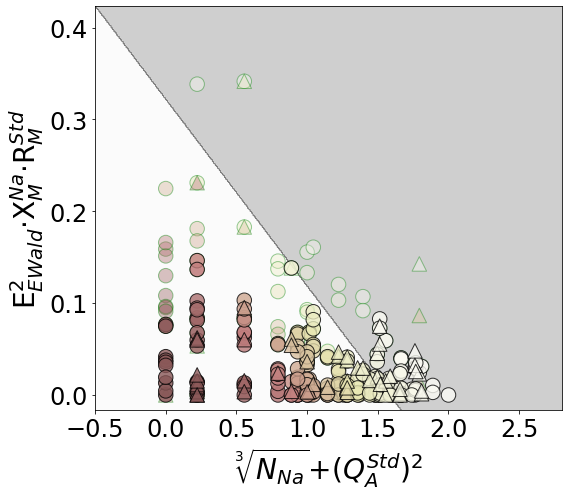

In [25]:
plt.figure(figsize=(8,7))
x_min, x_max = X_all_data[:,0].min()-0.5, X_all_data[:,0].max()+0.5
y_min, y_max = X_all_data[:,1].min()-50, X_all_data[:,1].max()+100

plot_stepx = (x_max-x_min)/500;
plot_stepy = (y_max-y_min)/500;
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_stepx),
                     np.arange(y_min, y_max, plot_stepy))
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.binary,alpha=0.2)

plt.scatter(best_X_train[CaGe_train_inds,0],best_X_train[CaGe_train_inds,1],cmap='pink_r',marker='o',
         s=210,c=CaGe_LSGS_train_proba[:,0],edgecolors=['g' for _ in range(len(CaGe_train_inds))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_train[CaGe_test_inds,0],best_X_train[CaGe_test_inds,1],cmap='pink_r',marker='^',
         s=210,c=CaGe_LSGS_test_proba[:,0],edgecolors=['g' for _ in range(len(CaGe_test_inds))],alpha=0.4,
            vmin=0.0,vmax=1.0)
plt.scatter(best_X_train[HfZr_train_inds,0],best_X_train[HfZr_train_inds,1],cmap='pink_r',marker='o',
         s=210,c=HfZr_LSGS_train_proba[:,0],edgecolors=['k' for _ in range(len(HfZr_train_inds))],alpha=0.8,
         vmin=0.0,vmax=1.0)
plt.scatter(best_X_test[HfZr_test_inds,0],best_X_test[HfZr_test_inds,1],cmap='pink_r',marker='^',
         s=210,c=HfZr_LSGS_test_proba[:,0],edgecolors=['k' for _ in range(len(HfZr_test_inds))],alpha=0.8,
         vmin=0.0,vmax=1.0)

_ = plt.yticks([0.00/norm_factor,0.10/norm_factor,0.20/norm_factor,0.30/norm_factor,0.40/norm_factor],
           [0.0,0.1,0.2,0.3,0.4])
_ = plt.xticks(fontsize=24); plt.yticks(fontsize=24)
plt.xlabel('$\sqrt[3]{N_{Na}}$+($Q_{A}^{Std}$)$^2$',fontsize=28)
plt.ylabel(r'E$_{EWald}^2$$\cdot$X$_{M}^{Na}$$\cdot$R$_{M}^{Std}$',fontsize=28)
plt.xlim((-0.5,2.8))
plt.ylim((-30,780))
plt.tight_layout()
plt.savefig('Fig_5d.pdf')